Hyperparameter exploration: plot the variation of the 3 hyperparameters vs added noise and vs number of physical model targets used in hyperparameter optimisation. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel as W
from gn_model import GN_model
font = { 'family' : 'sans-serif',
                'weight' : 'normal',
                'size'   : 14}
matplotlib.rc('font', **font)

In [3]:
data_dir = '/Users/joshnevin/Desktop/JavierBERdata/'
snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam100.csv", "r"), delimiter=",", dtype =float)#[21:60]
# snr = np.genfromtxt(open(str(data_dir) + "pchexpsnrsam300.csv", "r"), delimiter=",", dtype =float)
# pch = np.genfromtxt(open(str(data_dir) + "pchexppchsam300.csv", "r"), delimiter=",", dtype =float)

In [4]:
down_sample_factor = 3
snr = np.array([snr[i] for i in range(len(snr)) if i % down_sample_factor == 0])
pch = np.array([pch[i] for i in range(len(pch)) if i % down_sample_factor == 0])

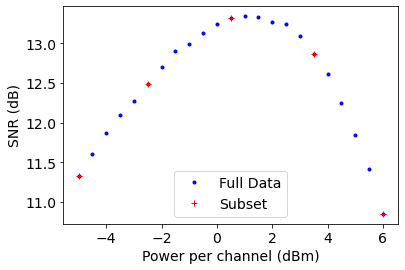

In [5]:
snr_sub = np.array([snr[0], snr[5], snr[11], snr[17], snr[-1]])
pch_sub = np.array([pch[0], pch[5], pch[11], pch[17], pch[-1]])
plt.plot(pch, snr, 'b.', label='Full Data')
plt.plot(pch_sub, snr_sub, 'r+', label='Subset')
plt.xlabel("Power per channel (dBm)")
plt.ylabel("SNR (dB)")
plt.legend()
plt.show()

In [6]:
phys_model = GN_model(100, 1550, 1, 0.78, 18, 0.18, 35, 40.2, 50, 4.3, 10, 16)

In [7]:
def shift_pch(pch, emp_pk):
    pch_gn = np.linspace(pch[0], pch[-1], 100)
    pch_shifted = pch - (emp_pk - pch_gn[np.argmax(phys_model.predict_snr(pch_gn))])
    return pch_shifted

def gen_phys_targets(model, pch, sigma, num_pts_phys):
    pch_gn_shifted = np.linspace(pch[0], pch[-1], num_pts_phys)
    snr_phys = (model.predict_snr(pch_gn_shifted) + np.random.normal(0, sigma, len(pch_gn_shifted)) ).reshape(-1,1)
    return pch_gn_shifted, snr_phys
    
def train_phys_gp(pch, pch_phys, snr, snr_phys):
    pch = pch.reshape(-1, 1)  # needed for SK learn input
    pch_phys = pch_phys.reshape(-1,1)
    snr = snr.reshape(-1,1)
    snr_phys = snr_phys.reshape(-1,1)
    kernel_sk = C(1, (1e-5, 1e5)) * RBF(1, (1e-5, 1e5)) +  W(1, (1e-5,1e5))
    gpr_phys = GaussianProcessRegressor(kernel=kernel_sk, n_restarts_optimizer = 20, normalize_y=True)
    gpr_phys.fit_phys(pch, pch_phys, snr, snr_phys)
    mu_sk_phys, std_sk_phys = gpr_phys.predict(pch, return_std=True)
    std_sk_phys = np.reshape(std_sk_phys,(np.size(std_sk_phys), 1)) 
    theta_phys = gpr_phys.kernel_.theta
    lml_phys = gpr_phys.log_marginal_likelihood()
    return mu_sk_phys, std_sk_phys, theta_phys, lml_phys

In [8]:
pch_shifted = shift_pch(pch, 1.2)

In [29]:
pch_gn_shifted, snr_phys = gen_phys_targets(phys_model, pch_shifted, 0.5, 20)

In [30]:
mu_sk_phys, std_sk_phys, theta_phys, lml_phys = train_phys_gp(pch_shifted, pch_gn_shifted, snr, snr_phys)
mu_sk_p2_phys = mu_sk_phys + 2*std_sk_phys 
mu_sk_n2_phys = mu_sk_phys - 2*std_sk_phys 

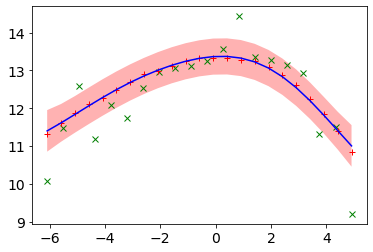

In [31]:
plt.plot(pch_gn_shifted, snr_phys, 'gx')
plt.plot(pch_shifted, snr, 'r+')
plt.plot(pch_shifted, mu_sk_phys, 'b-')
plt.fill(np.concatenate([pch_shifted, pch_shifted[::-1]]),
            np.concatenate([mu_sk_p2_phys,
                            (mu_sk_n2_phys)[::-1]]),
            alpha=0.3, fc='r', ec='None', label='2$\sigma$ confidence')
plt.show()

In [61]:
def hyp_var_sig(sig_range, pch, emp_pk, model, num_pts_phys):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    for sig in sig_range:
        pch_shifted = shift_pch(pch, emp_pk)
        pch_gn_shifted, snr_phys = gen_phys_targets(model, pch_shifted, sig, num_pts_phys)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch_shifted, pch_gn_shifted, snr, snr_phys)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
    return mus, ls, sigs, lmls, pred_stds
def hyp_var_num_pts(sigma, pch, emp_pk, model, num_pts_range):
    mus = []
    ls = []
    sigs = []
    lmls = []
    pred_stds = []
    for num_pts in num_pts_range:
        pch_shifted = shift_pch(pch, emp_pk)
        pch_gn_shifted, snr_phys = gen_phys_targets(model, pch_shifted, sigma, num_pts)
        pred_mean, pred_std, theta_phys, lml_phys = train_phys_gp(pch_shifted, pch_gn_shifted, snr, snr_phys)
        mus.append(theta_phys[0])
        ls.append(theta_phys[1])
        sigs.append(theta_phys[2])
        lmls.append(lml_phys)
        pred_stds.append(np.mean(pred_std))
    return mus, ls, sigs, lmls, pred_stds

In [54]:
sig_range = np.arange(0.01, 0.12, 0.01)
mus, ls, sigs, lmls, pred_stds = hyp_var_sig(sig_range, pch, 1.2, phys_model, 10)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

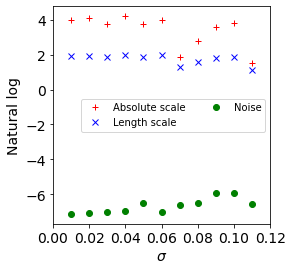

In [57]:
f, ax = plt.subplots()
plt.plot(sig_range, mus, 'r+', label='Absolute scale')
plt.plot(sig_range, ls, 'bx', label='Length scale')
plt.plot(sig_range, sigs, 'go', label='Noise')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend(ncol = 2, prop={'size':10})
plt.xlim([0, 0.12])
plt.xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
plt.xlabel("$\sigma$")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('figures/hyp_expl_all.pdf', dpi=200,bbox_inches='tight')
plt.show()

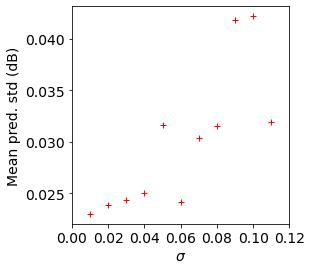

In [75]:
f, ax = plt.subplots()
plt.plot(sig_range, pred_stds, 'r+')
plt.xlim([0, sig_range[-1]])
plt.xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
plt.xlabel("$\sigma$")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('figures/hyp_expl_pred_std.pdf', dpi=200,bbox_inches='tight')
plt.show()

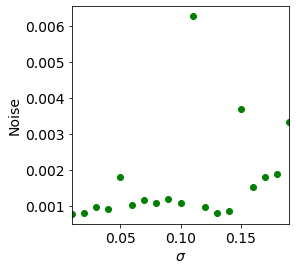

In [43]:
f, ax = plt.subplots()
#plt.plot(sig_range, lin_mus, 'r+', label='Absolute scale')
#plt.plot(sig_range, lin_ls, 'bx', label='Length scale')
plt.plot(sig_range, lin_sigs, 'go', label='Noise')
#plt.plot(sig_range, lin_mls, 'c.', label='Marginal likelihood')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([sig_range[0], sig_range[-1]])

plt.xlabel("$\sigma$")
plt.ylabel("Noise")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('figures/hyp_expl_noise.pdf', dpi=200,bbox_inches='tight')
plt.show()

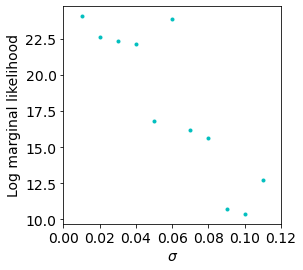

In [81]:
f, ax = plt.subplots()
#plt.plot(sig_range, lin_mus, 'r+', label='Absolute scale')
#plt.plot(sig_range, lin_ls, 'bx', label='Length scale')
plt.plot(sig_range, lmls, 'c.')
#plt.legend(ncol = 2, prop={'size':10})
plt.xlim([0, sig_range[-1]])
plt.xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
plt.xlabel("$\sigma$")
plt.ylabel("Log marginal likelihood")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.savefig('figures/hyp_expl_lml.pdf', dpi=200,bbox_inches='tight')
plt.show()

In [77]:
num_pts_range = np.arange(5, 31, 1, dtype=int)
mus_p, ls_p, sigs_p, lmls_p, pred_stds_p = hyp_var_num_pts(0.03, pch, 1.2, phys_model, num_pts_range)
lin_mus = np.exp(mus)
lin_ls = np.exp(ls)
lin_sigs = np.exp(sigs)
lin_mls = np.exp(lmls)

/Users/joshnevin/sklearnforked/scikit-learn/sklearn/gaussian_process/_gpr.py:746: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


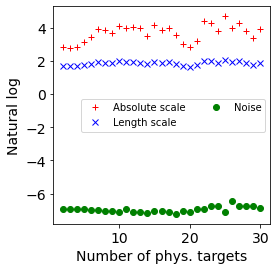

In [78]:
f, ax = plt.subplots()
plt.plot(num_pts_range, mus_p, 'r+', label='Absolute scale')
plt.plot(num_pts_range, ls_p, 'bx', label='Length scale')
plt.plot(num_pts_range, sigs_p, 'go', label='Noise')
#plt.plot(sig_range, lmls, 'c.', label='Marginal likelihood')
plt.legend(ncol = 2, prop={'size':10})
#plt.xlim([0, 0.12])
#plt.xticks([0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12])
plt.xlabel("Number of phys. targets")
plt.ylabel("Natural log")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_all.pdf', dpi=200,bbox_inches='tight')
plt.show()

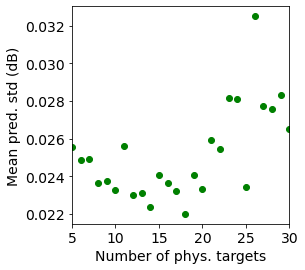

In [79]:
f, ax = plt.subplots()
plt.plot(num_pts_range, pred_stds_p, 'go')
plt.xlim([5, 30])
plt.xticks([5, 10, 15, 20, 25, 30])
plt.xlabel("Number of phys. targets")
plt.ylabel("Mean pred. std (dB)")
f.patch.set_facecolor('w')
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
#plt.savefig('figures/hyp_expl_num_pts_pred_std.pdf', dpi=200,bbox_inches='tight')
plt.show()

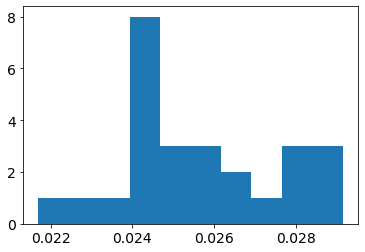

In [71]:
plt.hist(pred_stds_p)
plt.show()